In [11]:
import pandas as pd
import plotly.express as px
import datetime
from IPython.core.display import HTML
import pickle
import torch
import clip
import cv2
from PIL import Image

In [12]:
# Load the open CLIP model
device = "mps" if getattr(torch,'has_mps',False) else "gpu" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [13]:
df = pd.read_csv('../data/with_aug/all_with_uuid.csv', index_col=0)

In [14]:
def get_video_frames(video_name):

  # The frame images will be stored in video_frames
  video_frames = []

  # Open the video file
  capture = cv2.VideoCapture(video_name)
  fps = round(capture.get(cv2.CAP_PROP_FPS))
  print()

  current_frame = 0
  while capture.isOpened():
    # Read the current frame
    ret, frame = capture.read()

    # Convert it to a PIL image (required for CLIP) and store it
    if ret == True:
      video_frames.append(Image.fromarray(frame[:, :, ::-1]))
    else:
      break

    # Skip N frames
    current_frame += fps
    capture.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

  # Print some statistics
  print(f"Frames extracted: {len(video_frames)}, fps: {fps}")
  return video_frames, fps

In [25]:
def show_results(index, display_heatmap=True, display_results_count=3):
    id = df.iloc[index]['id']
    search_query = df.iloc[index]['comment']

    if 'bitchute' in df.iloc[index]['url']:
      video_id = df.iloc[index]['url'].split('/')[-2]
    else:
      video_id = df.iloc[index]['url'].split('https://www.youtube.com/watch?v=')[1].split('&ab_channel=')[0].split('&t=')[0]
    
    video_frames, fps = get_video_frames(f'../data/videos/{video_id}.mp4')

    with open(f'../data/CLIP_embeddings/{id}.pickle', 'rb') as handle:
        data = pickle.load(handle)
    with torch.no_grad():
        text_features = model.encode_text(clip.tokenize(search_query, truncate=True).to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
    similarities = data['similarities']

    values, best_photo_idx = similarities.topk(display_results_count, dim=0)

    # Display the heatmap
    if display_heatmap:
        print(f"Search query:\t {df.iloc[index]['comment']}\n heatmap over the frames of the video:")
        fig = px.imshow(similarities.T.cpu().numpy(), height=50, aspect='auto', color_continuous_scale='viridis')
        fig.update_layout(coloraxis_showscale=False)
        fig.update_xaxes(showticklabels=False)
        fig.update_yaxes(showticklabels=False)
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
        fig.show()
        print()

    # Display the top 3 frames
    for frame_id in best_photo_idx:
        display(video_frames[frame_id])

        # Find the timestamp in the video and display it
        seconds = round(frame_id.cpu().numpy()[0] * fps / fps)
        if 'youtube' in df.iloc[index]['url']:
          display(HTML(f"Found at {str(datetime.timedelta(seconds=seconds))} (<a target=\"_blank\" href=\"{df.iloc[index]['url']}&t={seconds}\">link</a>)"))
        else:
          display(HTML(f"Found at {str(datetime.timedelta(seconds=seconds))} (<a target=\"_blank\" href=\"{df.iloc[index]['url']}\">link</a>)"))


Frames extracted: 138, fps: 30
Search query:	 well duuhh!!! Indians cant act,, Bollywood much???
 heatmap over the frames of the video:


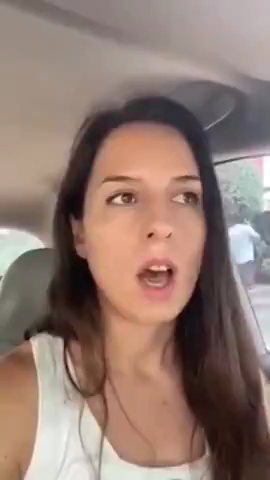

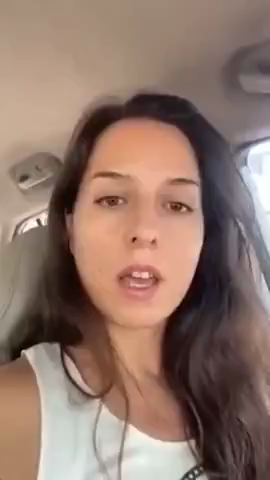

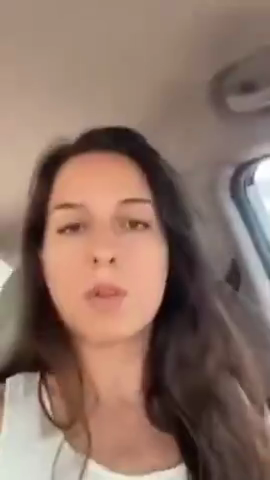

In [26]:
show_results(0)


Frames extracted: 62, fps: 30
Search query:	 some believe that she is the master of bending poles to her will
 heatmap over the frames of the video:


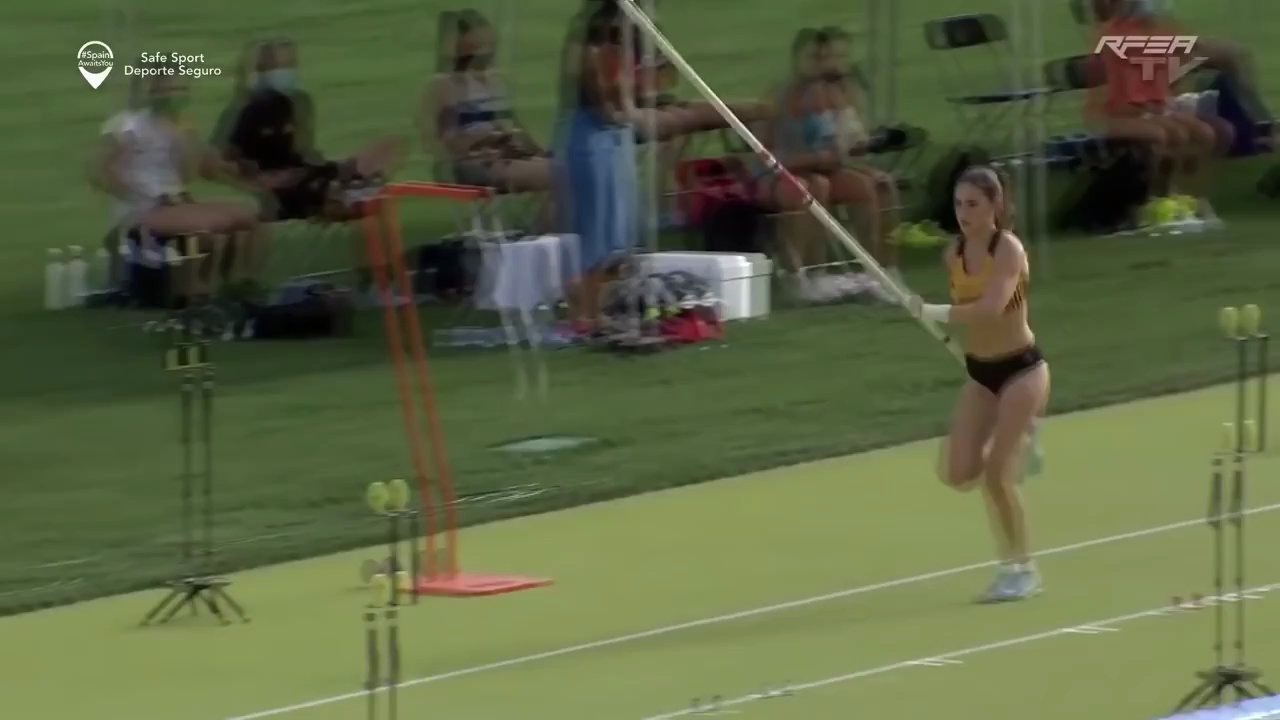

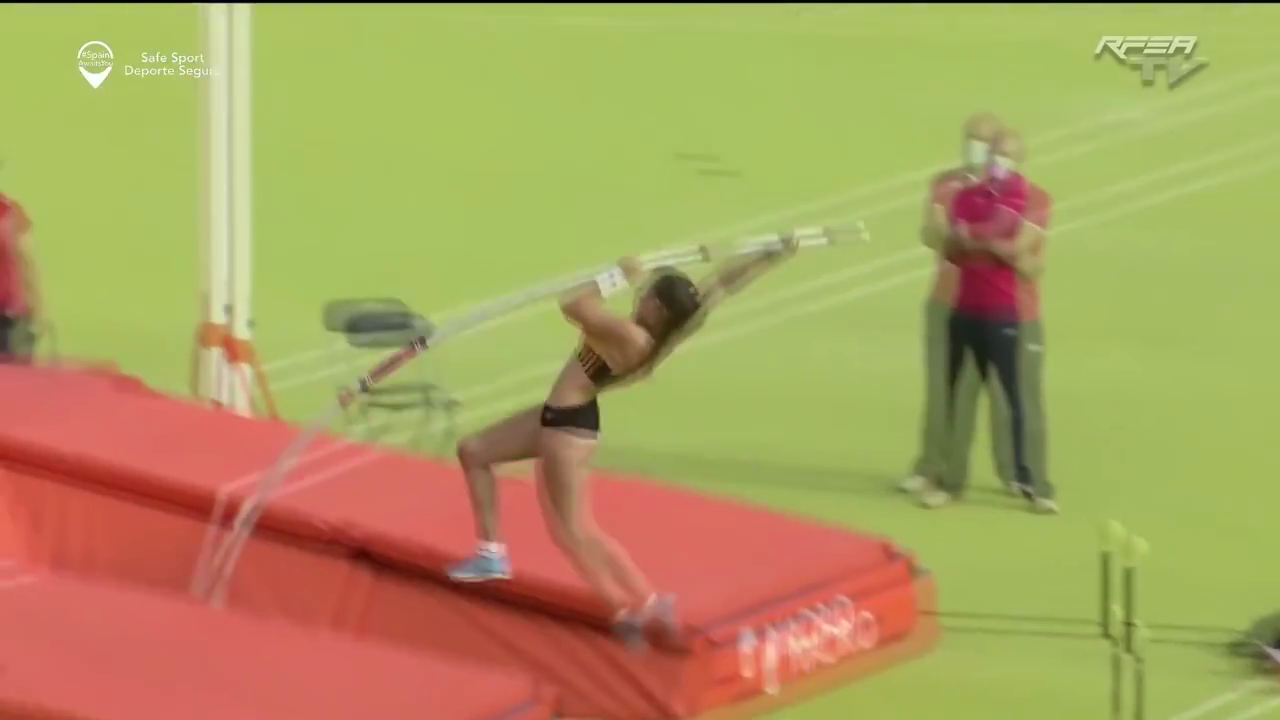

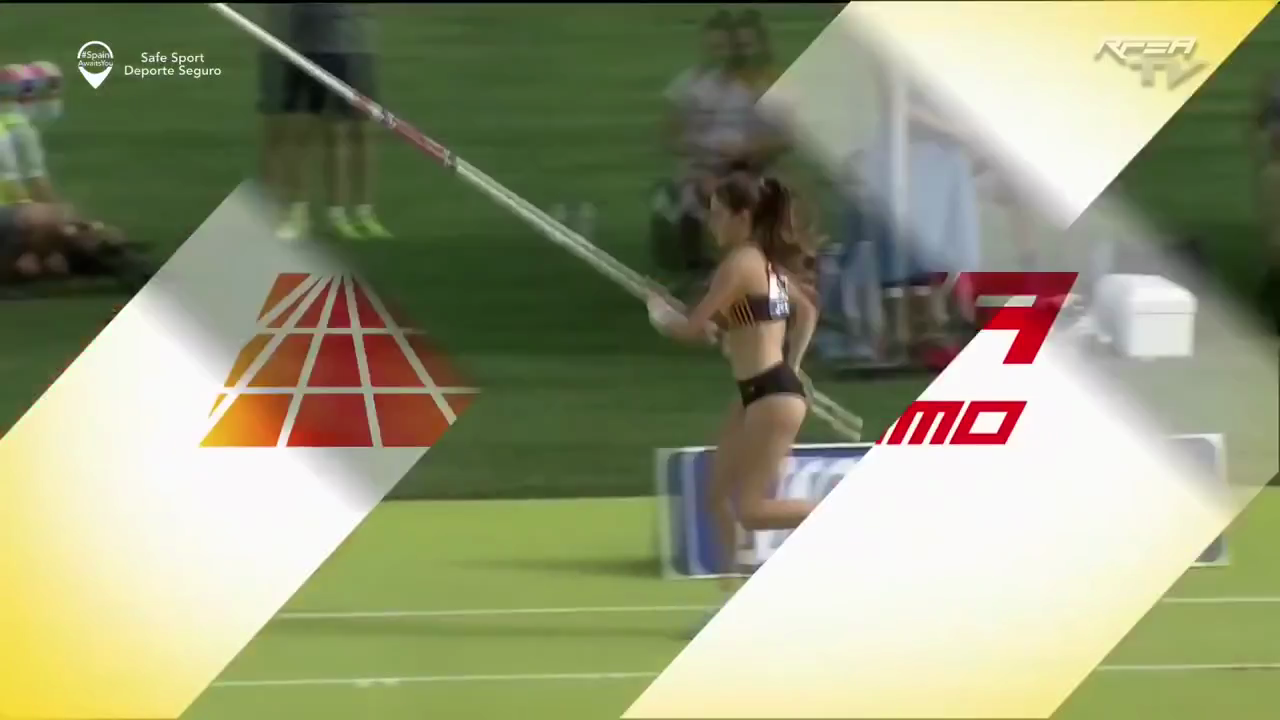

In [28]:
show_results(2000)


Frames extracted: 477, fps: 30
Search query:	 i prefer the dry taste of chicken to moisture
 heatmap over the frames of the video:


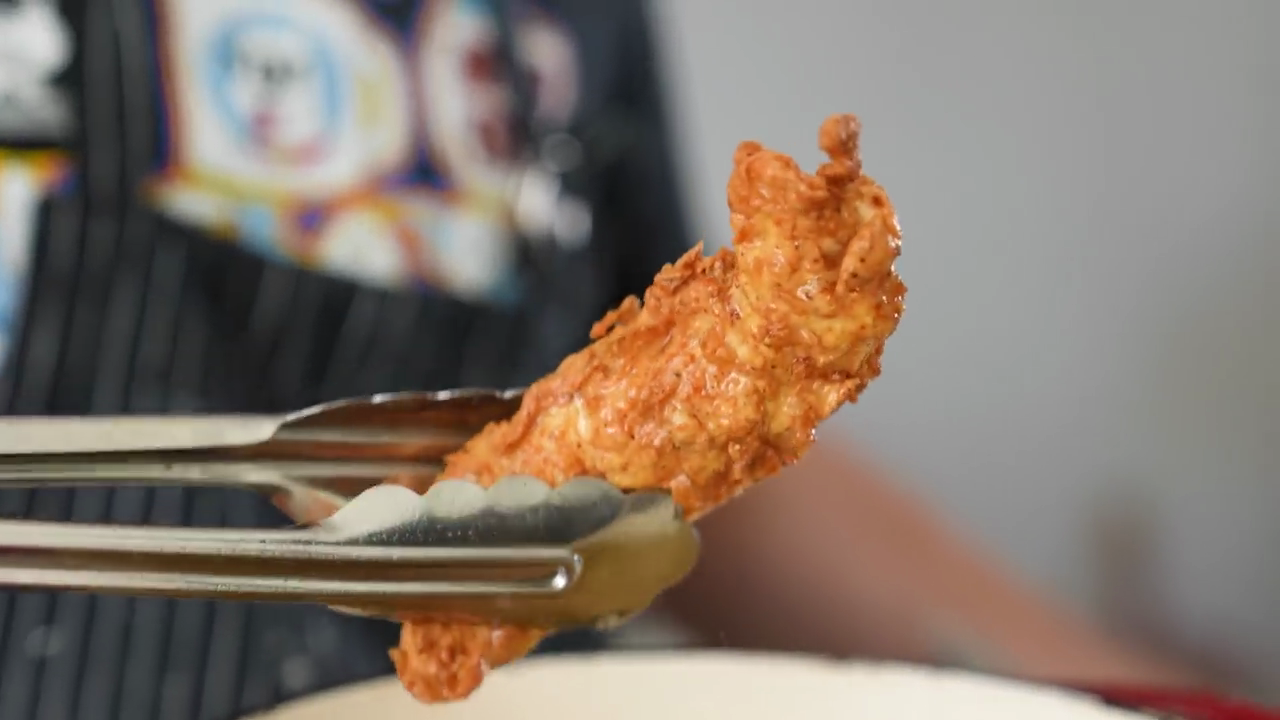

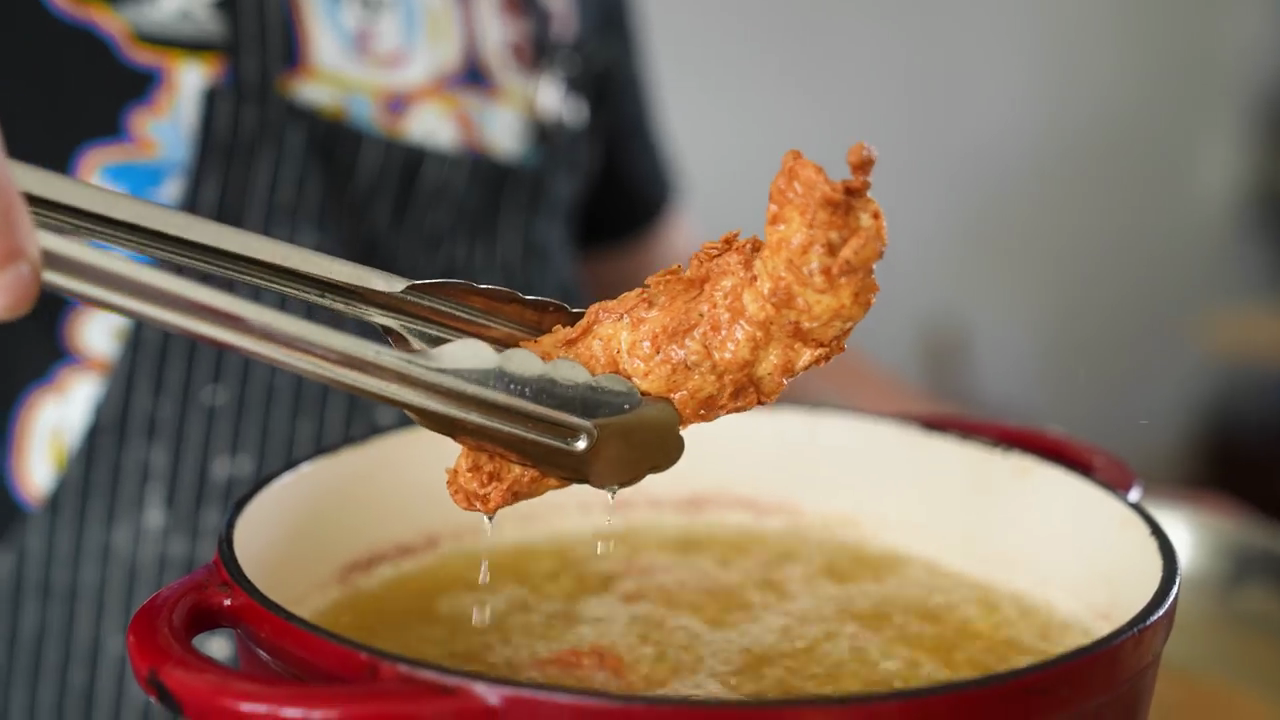

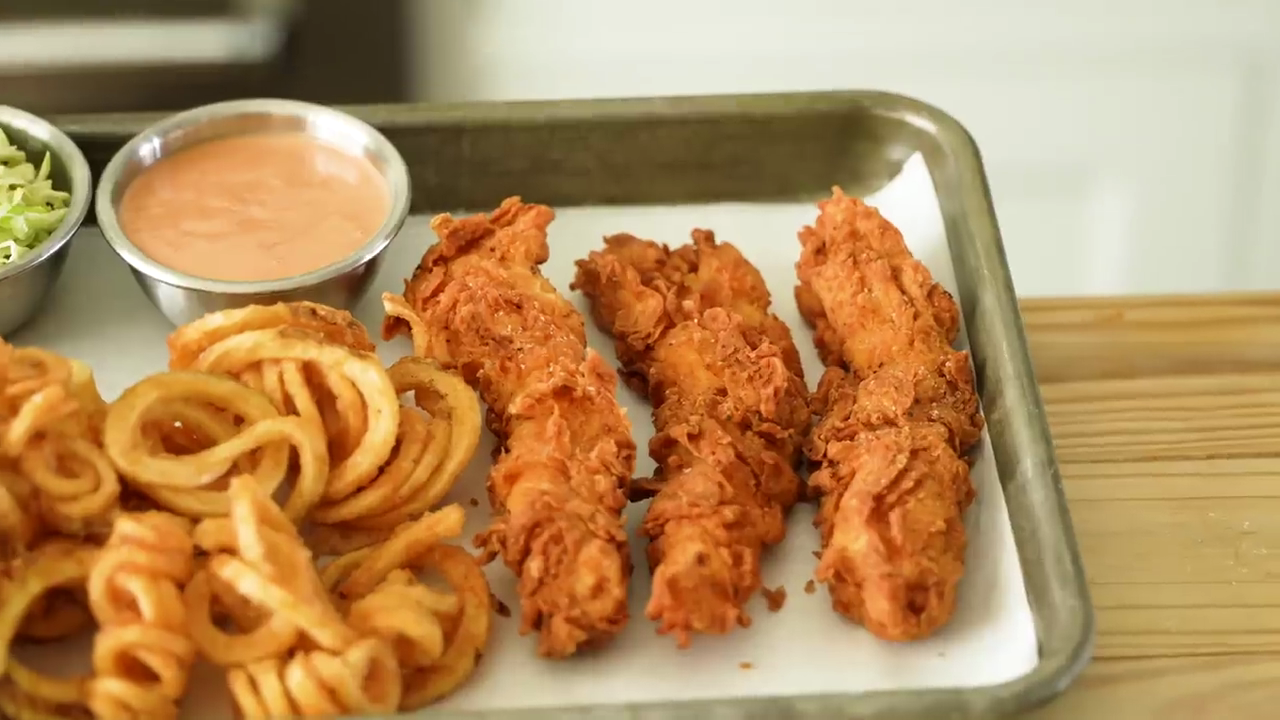

In [29]:
show_results(6000)


Frames extracted: 149, fps: 30
Search query:	 and i love that khlo's personality has never changed
 heatmap over the frames of the video:


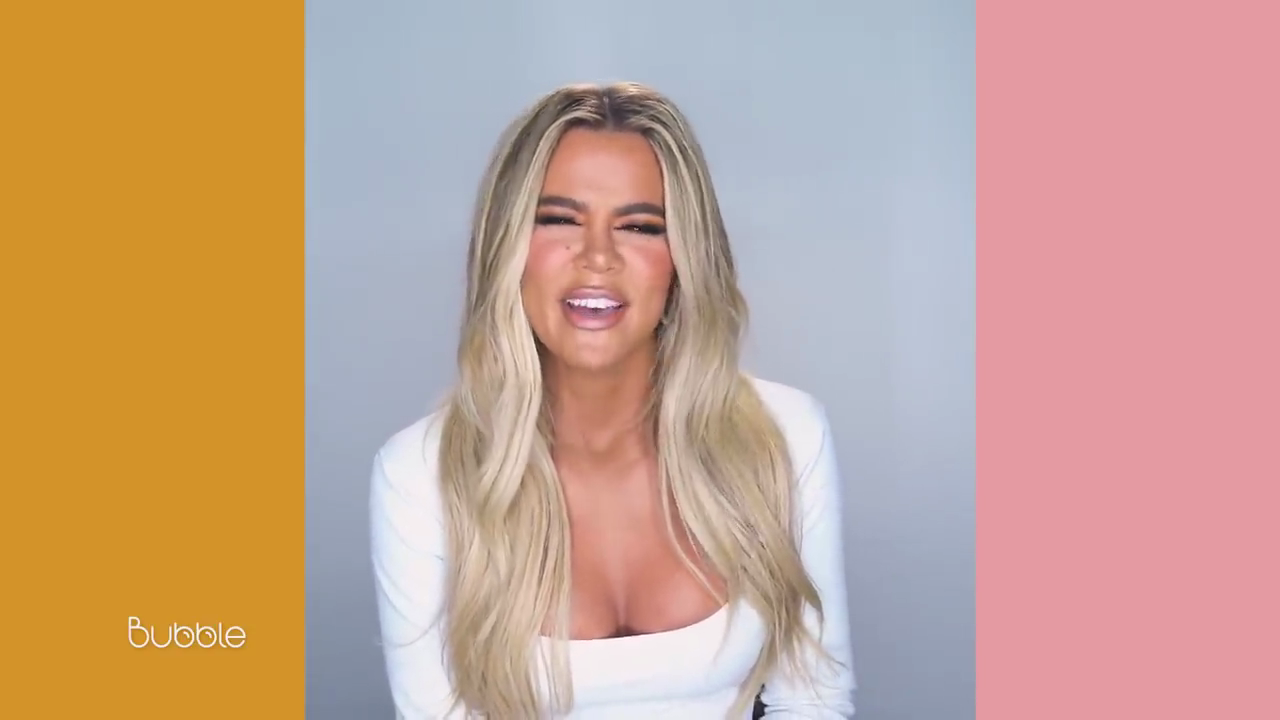

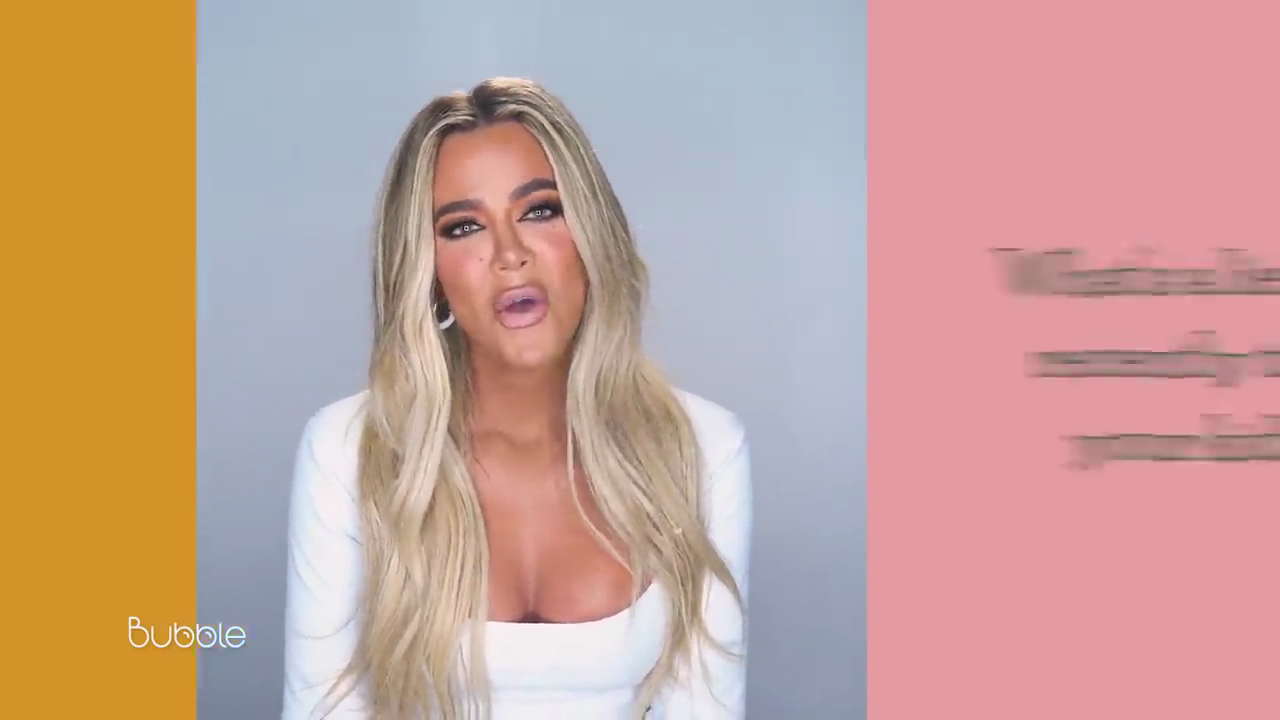

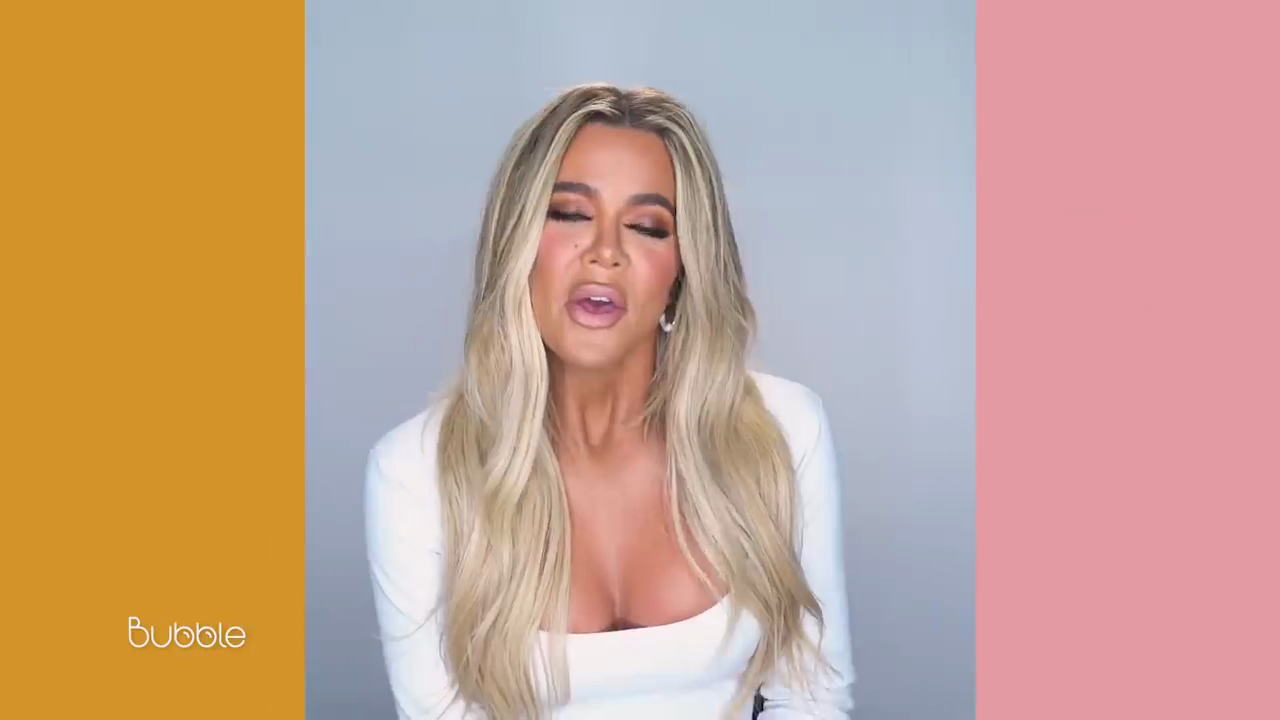

In [30]:
show_results(9000)